In [185]:
from time import time
from datetime import datetime
import os
import sys
import math
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
import matplotlib.font_manager
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker

In [186]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# 定义 log10 函数
def log10(x):
    return torch.log(x) / torch.log(torch.tensor(10.0, dtype=DTYPE))
df = {}
Shuffle = False
# 读取数据
url_lf = 'Oscillatory/Data_LF_AS_Gp.xlsx'
url_hf = 'Oscillatory/Data_HF_AS_Gp.xlsx'

df_LF = pd.read_excel(url_lf, sheet_name=None)
data_LF = [[k, v] for k, v in df_LF.items()]  # k is the sheet name, v is the pandas df

df_HF = pd.read_excel(url_hf, sheet_name=None)
data_HF = [[k, v] for k, v in df_HF.items()]  # k is the sheet name, v is the pandas df

# 转换为 PyTorch 张量
x1_d_LF = torch.tensor(data_LF[sample][1]['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_d_LF = torch.tensor(data_LF[sample][1]['Temperature'].values, dtype=torch.float32).view(-1, 1)
x3_d_LF = torch.tensor(data_LF[sample][1]['AngFreq'].values, dtype=torch.float32).view(-1, 1)
y1_d_LF = torch.tensor(data_LF[sample][1]['StorageM'].values, dtype=torch.float32).view(-1, 1)

sample = 0
data_HF[sample][1] = data_HF[sample][1].dropna()
df_hf = data_HF[sample][1]  # entire data

data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].Temperature != 50.]

df_train = data_HF[sample][1]  # train data

x1_d_HF = torch.tensor(data_HF[sample][1]['Strain'].values, dtype=torch.float32).view(-1, 1)
x2_d_HF = torch.tensor(data_HF[sample][1]['Temperature'].values, dtype=torch.float32).view(-1, 1)
x3_d_HF = torch.tensor(data_HF[sample][1]['AngFreq'].values, dtype=torch.float32).view(-1, 1)
y1_d_HF = torch.tensor(data_HF[sample][1]['StorageM'].values, dtype=torch.float32).view(-1, 1)
y1_d_HF_std = torch.tensor(data_HF[sample][1]['StorageMSTD'].values, dtype=torch.float32).view(-1, 1)

# 对 HF 数据进行对数变换
x1_d_HF = torch.log10(x1_d_HF)
x3_d_HF = torch.log10(x3_d_HF)
y1_d_HF = torch.log10(y1_d_HF)

# 计算边界
x1min, x1max = torch.min(x1_d_HF), torch.max(x1_d_HF)
x2min, x2max = torch.min(x2_d_HF), torch.max(x2_d_HF)
x3min, x3max = torch.min(x3_d_HF), torch.max(x3_d_HF)
y1min, y1max = torch.min(y1_d_HF), torch.max(y1_d_HF)

wmin, wmax = np.log10(0.1), np.log10(600.)
lb = torch.tensor([x1min, 10., wmin, y1min], dtype=torch.float32).numpy()
ub = torch.tensor([x1max, 50., wmax, y1max], dtype=torch.float32).numpy()
# 归一化函数
def norm(vectors, lb, ub):
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors
x1_d_HF = norm(x1_d_HF, lb[0], ub[0])
x2_d_HF = norm(x2_d_HF, lb[1], ub[1])
x3_d_HF = norm(x3_d_HF, lb[2], ub[2])
y1_d_HF = norm(y1_d_HF, lb[3], ub[3])

# 合并数据
X_data_HF = torch.cat([x1_d_HF, x2_d_HF, x3_d_HF], dim=1)
y_data_HF = torch.cat([y1_d_HF], dim=1)

X_data_LF = torch.cat([x1_d_LF, x2_d_LF, x3_d_LF], dim=1)
y_data_LF = torch.cat([y1_d_LF], dim=1)
# 定义模型
in_dim, out_dim = 3, 1

将训练数据转化为ＲＮＮ形式

In [187]:
# 定义序列长度
seq_length = 1  # 假设每个序列包含24个时间步

# 创建序列数据
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length+1):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length-1, -1])
    return torch.stack(X), torch.stack(y)



In [188]:
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model using RNN."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
       # 添加LSTM层
        self.lstm_layer = nn.LSTM(input_dim, num_neurons_per_layer, num_hidden_layers, batch_first=True)
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            for name, param in self.lstm_layer.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(param)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            for name, param in self.lstm_layer.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):
               # 进入输入层
        Z=self.input_layer(X)
        # 在Z的中间加一个维度，表示序列长度
       # Z = X.unsqueeze(1)  # 假设序列长度为1
        # 通过LSTM层
       # Z, _ = self.lstm_layer(Z)
        # 通过输出层输出
      #  Z = Z[:, -1, :]  # 取最后一个时间步的输出
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        
        # 通过输出层输出
        Z = self.out(Z)
        return Z

In [189]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self,  model_HF_nl):
        self.model_HF_nl = model_HF_nl # 高保真非线性模型
        # Initialize history of losses and global iteration counter
        self.hist = [] # loss历史列表
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_LF, X_data_HF, y_data_LF, y_data_HF):   
        y_pred_HF_nl = self.model_HF_nl(X_data_HF)
        y_pred_HF = y_pred_HF_nl 
        y_pred_LF=self.model_HF_nl(X_data_LF)
        Loss_data_HF = torch.mean((y_data_HF - y_pred_HF)**2)
        Loss_data_LF=torch.mean((y_pred_LF-y_data_LF)**2)
        loss =  Loss_data_HF
        loss_frac = [ Loss_data_HF.item()]
        return loss, loss_frac
    
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer, X_data_LF, X_data_HF, y_data_LF, y_data_HF,scheduler,N=1001):
        """This method performs a gradient descent type optimization."""        
        for i in range(N):
            # 梯度清0
            optimizer.zero_grad()
            # 计算loss          
            loss, loss_frac = self.loss_fn( X_data_LF,X_data_HF,y_data_LF, y_data_HF)
            # 反向传播计算梯度
            loss.backward()
            # 根据loss调度学习率
            scheduler.step(loss)
            # 反向传播更新权重和偏置
            optimizer.step()

            # 记录loss并计算相对误差
            self.loss_frac = loss_frac
            self.current_loss = loss.item()
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error,N)  # Pass max_relative_error to the callback function
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3: # in %
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 3)))
                break

    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 100 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist.append(self.current_loss)
        self.iter+=1
    
    # 绘制损失函数曲线
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$loss$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

        return ax

In [190]:
# 定义模型
model_HF_nl = PINN_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_hidden_layers=6,
                             num_neurons_per_layer=64,
                             activation='relu')

# 初始化 PINNSolver
solver = PINNSolver(model_HF_nl)

In [191]:
# 定义学习率调度器
lr = 0.0001
optimizer = optim.Adam(list(model_HF_nl.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True)
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(3000) + 1  # 训练迭代次数

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        t0 = time()
        solver.solve_with_PyTorch_optimizer(optimizer, X_data_LF,X_data_HF, y_data_LF,y_data_HF,scheduler,N=N)
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

It 0,000: Loss = 4.5322e-01, Max. rel. error = 100 %
It 0,100: Loss = 1.7720e-01, Max. rel. error = 33.99 %
It 0,200: Loss = 3.7351e-02, Max. rel. error = 39.4 %
It 0,300: Loss = 6.5594e-03, Max. rel. error = 9.44 %
It 0,400: Loss = 4.7667e-03, Max. rel. error = 4.48 %
It 0,500: Loss = 3.6495e-03, Max. rel. error = 6.22 %
It 0,600: Loss = 2.3427e-03, Max. rel. error = 10.5 %
It 0,700: Loss = 1.2034e-03, Max. rel. error = 15.31 %
It 0,800: Loss = 5.6256e-04, Max. rel. error = 16.41 %
It 0,900: Loss = 2.5485e-04, Max. rel. error = 15.56 %
It 1,000: Loss = 1.3901e-04, Max. rel. error = 10.38 %
It 1,100: Loss = 8.8909e-05, Max. rel. error = 8.23 %
It 1,200: Loss = 6.1516e-05, Max. rel. error = 7.21 %
It 1,300: Loss = 4.6207e-05, Max. rel. error = 5.38 %
It 1,400: Loss = 3.7169e-05, Max. rel. error = 3.46 %
It 1,500: Loss = 3.2579e-05, Max. rel. error = 2.28 %
It 1,600: Loss = 2.9505e-05, Max. rel. error = 1.76 %
It 1,700: Loss = 2.7264e-05, Max. rel. error = 1.35 %
It 1,800: Loss = 2.5611e

<Axes: xlabel='$n_{epoch}$', ylabel='$loss$'>

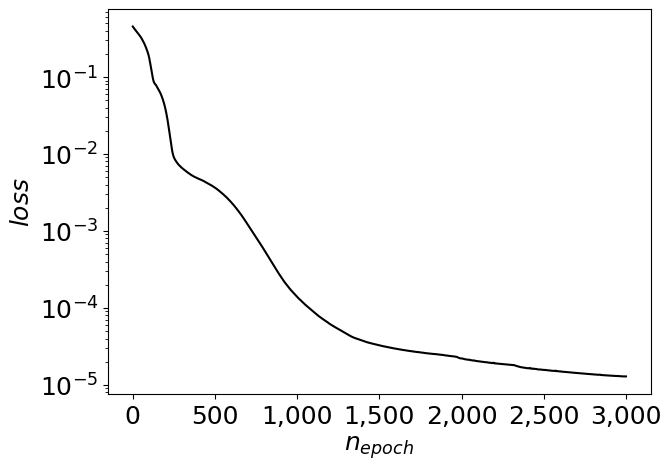

In [192]:
solver.plot_loss_history()

/tmp/ipykernel_7249/4188925124.py:20: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  comm = df_train.merge(data_test_fs[sample][1], how='inner')


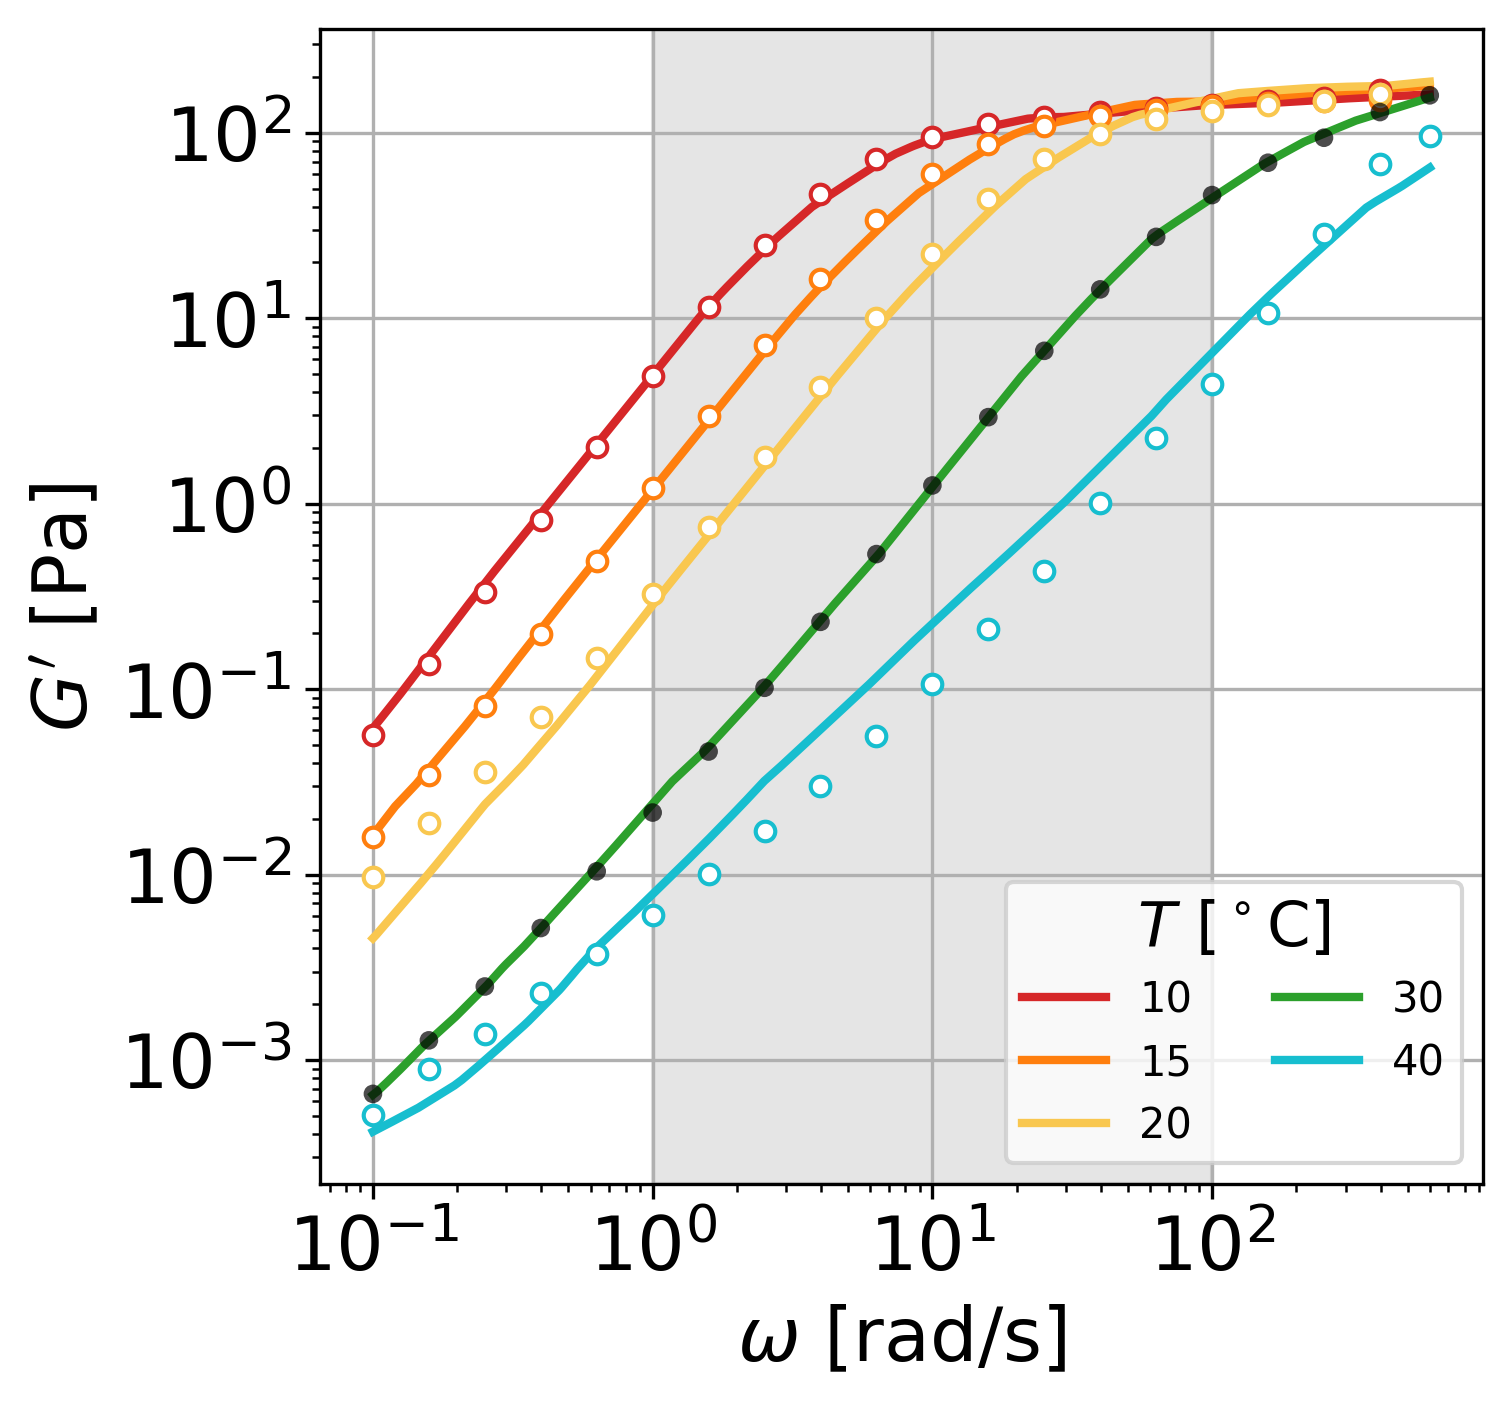

In [193]:
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue']

url_test_fs = 'Oscillatory/Data_HF_FS_test.xlsx'
# Uncomment to run locally
# url_test_fs = 'Data_HF_FS_test.xlsx'

df_test_fs = pd.read_excel(url_test_fs, sheet_name=None)
data_test_fs = [[k, v] for k, v in df_test_fs.items()]

sample = 0
data_test_fs[sample][1] = data_test_fs[sample][1].dropna()

comm = df_train.merge(data_test_fs[sample][1], how='inner')
comm_T = np.unique(comm['Temperature'])

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N_exp = 1000
w_plot = norm(np.linspace(wmin, wmax, N_exp).reshape(-1, 1), wmin, wmax)
T_range = [10., 15., 20., 30., 40.]
St_range = [10., 10., 10., 100., 100.]

St_pred_fs, T_pred_fs, w_pred_fs = [], [], []
Gp_pred_fs = []
# 序列化数据
def sequences(data, seq_length):
    X= []
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:i+seq_length])
    return torch.stack(X)
for i in range(len(T_range)):
    df_plot = data_test_fs[sample][1][data_test_fs[sample][1].Temperature == T_range[i]]
    x1_test = df_plot['Strain']
    x2_test = df_plot['Temperature']
    x3_test = df_plot['AngFreq']
    y1_test = df_plot['StorageM']
    y1_test_std = df_plot['StorageMSTD']
    
    St_plot = norm(np.log10(St_range[i]) * np.ones(N_exp).reshape(-1, 1), lb[0], ub[0])
    T_plot = norm(T_range[i] * np.ones(N_exp).reshape(-1, 1), lb[1], ub[1])
    X_LF = torch.cat([torch.tensor(St_plot, dtype=torch.float32), torch.tensor(T_plot, dtype=torch.float32), torch.tensor(w_plot, dtype=torch.float32)], dim=1)
    # X_LF=sequences(X_LF,seq_length)
    y_MF = model_HF_nl(X_LF)
    St_pred_fs = np.append(St_pred_fs, St_plot)
    T_pred_fs = np.append(T_pred_fs, T_plot)
    w_pred_fs = np.append(w_pred_fs, w_plot)
    Gp_pred_fs = np.append(Gp_pred_fs, y_MF.detach().numpy())
    if comm_T == T_range[i]:
        condition = (x3_test >= min(comm['AngFreq'])) & (x3_test <= max(comm['AngFreq']))
        ax.scatter(x3_test[condition], y1_test[condition],
                   s=20, color='k', zorder=10, alpha=0.7, edgecolors='none')
        ax.scatter(x3_test[~condition], y1_test[~condition],
                   alpha=1., zorder=10, s=22, marker='o', lw=1., facecolors='white', edgecolors=colors[i])
    else:
        ax.scatter(x3_test, y1_test,
                   alpha=1., zorder=10, s=22, marker='o', lw=1., facecolors='white', edgecolors=colors[i])

    ax.plot(10 ** denorm(w_plot[seq_length-1:], lb[2], ub[2]), 10 ** denorm(y_MF.detach().numpy(), lb[3], ub[3]),
             label=int(T_range[i]), lw=2., color=colors[i], alpha=1.)

    legend = ax.legend(ncol=2, loc='lower right', title='$T$ [$\mathrm{^\circ C}$]', fontsize=10)
    plt.setp(legend.get_title(), fontsize=15)

ax.axvspan(1, 100, color='gray', alpha=0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$G\'$ $\mathrm{[Pa]}$')
ax.set_xlabel('$\omega$ $\mathrm{[rad/s]}$')
ax.grid()
# plt.savefig("datetime.now().strftime("%Y_%m_%d-%H_%M_%S")+"_FS_Gp.png", bbox_inches='tight', dpi=600);
plt.show()

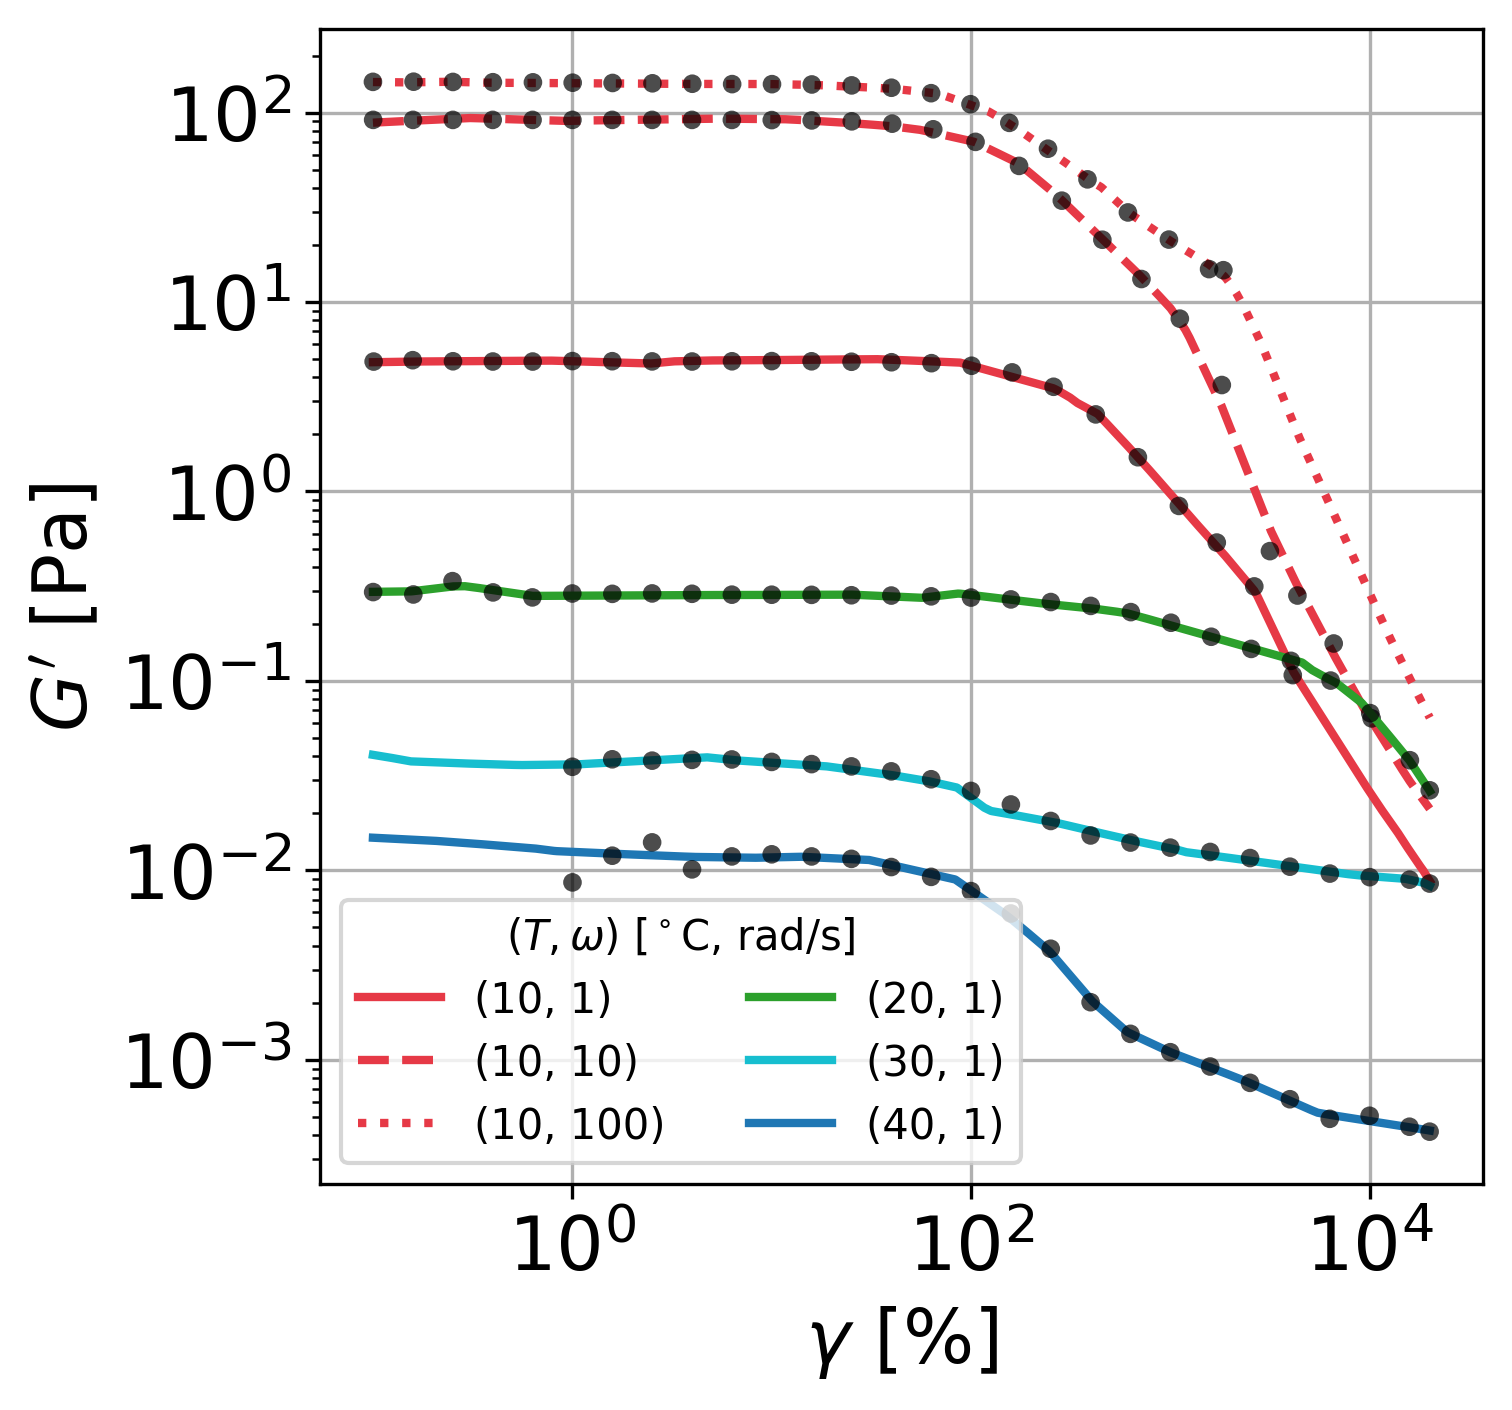

In [194]:
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['#e63946', '#e63946', '#e63946', 'tab:green', 'tab:cyan', 'tab:blue']
ls = ['solid', 'dashed', ':', 'solid', 'solid', 'solid']

url_test_as = 'Oscillatory/Data_HF_AS_plot.xlsx'
# Uncomment to run locally
# url_test_as = 'Data_HF_AS_plot.xlsx'

df_test_as = pd.read_excel(url_test_as, sheet_name=None)
data_test_as = [[k, v] for k, v in df_test_as.items()]

sample = 0
data_test_as[sample][1] = data_test_as[sample][1].dropna()

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N_exp = 1000

St_plot = norm(np.linspace(lb[0], ub[0], N_exp).reshape(-1, 1), lb[0], ub[0])
uniques = np.unique(data_test_as[sample][1][['Temperature', 'AngFreq']], axis=0)

St_pred, T_pred, w_pred = [], [], []
Gp_pred = []

for i in range(len(uniques)):
    df_plot = data_test_as[sample][1][data_test_as[sample][1].Temperature == uniques[i][0]]
    df_plot = df_plot[df_plot.AngFreq == uniques[i][1]]
    x1_test = df_plot['Strain']
    x2_test = df_plot['Temperature']
    x3_test = df_plot['AngFreq']
    y1_test = df_plot['StorageM']
    y1_test_std = df_plot['StorageMSTD']

    T_plot = norm(uniques[i][0] * np.ones(N_exp).reshape(-1, 1), lb[1], ub[1])
    w_plot = norm(np.log10(uniques[i][1]) * np.ones(N_exp).reshape(-1, 1), wmin, wmax)

    X_LF = torch.cat([torch.tensor(St_plot, dtype=torch.float32), torch.tensor(T_plot, dtype=torch.float32), torch.tensor(w_plot, dtype=torch.float32)], dim=1)
   # X_LF=sequences(X_LF,seq_length)
    y_MF = model_HF_nl(X_LF) 

    St_pred = np.append(St_pred, St_plot)
    T_pred = np.append(T_pred, T_plot)
    w_pred = np.append(w_pred, w_plot)
    Gp_pred = np.append(Gp_pred, y_MF.detach().numpy())

    ax.plot(10 ** denorm(St_plot, lb[0], ub[0]), 10 ** denorm(y_MF.detach().numpy(), lb[3], ub[3]),
            label='({}, {})'.format(int(uniques[i][0]), int(uniques[i][1])),
            lw=2, color=colors[i], alpha=1., linestyle=ls[i])
    
    if uniques[i][0] in np.unique(denorm(x2_d_HF, lb[1], ub[1])):
        ax.scatter(x1_test, y1_test,
                   s=20, color='k', zorder=2, alpha=0.7, edgecolors='none')
    else:
        ax.scatter(x1_test, y1_test, color=colors[i],
                   alpha=1., zorder=2, s=20, marker='o', lw=1., facecolors='white', edgecolors=colors[i])

legend = ax.legend(ncol=2, loc='best',
                    title='$(T, \omega)$ [$\mathrm{^\circ C}$, $\mathrm{rad/s}$]', fontsize=10)
plt.setp(legend.get_title(), fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$G\'$ $\mathrm{[Pa]}$')
ax.set_xlabel('$\gamma$ $\mathrm{[\%]}$')
ax.grid()
# plt.savefig("datetime.now().strftime("%Y_%m_%d-%H_%M_%S")+"_AS_Gp.png", bbox_inches='tight', dpi=600);
plt.show()